In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.utils import pickle_open
from cohlib.plot import draw_raster_single
from cohlib.sample import sample_spikes_from_xs

from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence

In [2]:
def Gamma_est_from_zs(zs, dc=False):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams[lams < 0] = 0
    return lams

In [27]:
from cohlib.alg.em_sgc import construct_Gamma_full_real
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
def get_alpha_data(alpha, link, init_type, optim_type, scaling_factor=1, k=0, track=None,
                    win=1000,
                    L=50,
                    C=1,
                    emiter=20,
                    K=2,
                    seed=42,
                    model_path=None,
                    data_path=None,
                    not_cross=False
):
    fs = 1000
    delta = 1/fs


    alpha=float(alpha)

    sample_length = win
    em_iters = emiter

    if data_path is None:
        data_path = f'saved/synthetic_data/simple_synthetic_logpoisson_fixed_gamma_{K}_{L}_{sample_length}'
    
    data_load = pickle_open(data_path)
    latent = data_load['latent']
    Gamma = latent['Gamma']
    zs = latent['zs']
    xs = latent['xs']




    # obs = data_load['observed']
    alphas = np.array([alpha for k in range(K)])

    lams = cif_alpha_relu(alphas, xs)
    spikes = sample_spikes_from_xs(lams, C, delta=1/fs, obs_model='poisson')
    Gamma_zest = Gamma_est_from_zs(zs)



    spikes_mc = spikes.mean(1)
    # ft_spikes = rfft(spikes_mc*(fs/(2*np.pi)), axis=2, norm='backward')
    ft_spikes = rfft(spikes_mc, axis=2, norm='backward')
    S_naive = (ft_spikes * ft_spikes.conj()).mean((0)).real
    S_naive = S_naive[k,1:51]

    ft_spikes0 = ft_spikes[:,0,1:]
    ft_spikes1 = ft_spikes[:,1,1:]

    if not_cross is True:
        model_path = f'saved/fitted_models/simple_synthetic_{link}poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'
    else:
        model_path = f'saved/fitted_models/cross_data_simple_delta{link}_poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted.pkl'

    model_load = pickle_open(model_path)
    num_J_vars = int(model_load['Gamma'].shape[0]*2)
    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars, invert=True)

    S_true = Gamma[:50,k,k].real
    S_oracle = Gamma_zest[:50,k,k].real
    S_init = Gamma_init[:50,k,k].real

    S_true = S_true*scaling_factor
    S_oracle = S_oracle*scaling_factor
    S_init = S_init*scaling_factor

    coh_naive = estimate_coherence(ft_spikes0, ft_spikes1)
    coh_naive = coh_naive[:50]
    coh_true = thr_coherence(Gamma[:50,:,:])
    coh_oracle = thr_coherence(Gamma_zest[:50,:,:])
    coh_init = thr_coherence(Gamma_init[:50,:,:])



    if track is not None:
        S_model = []
        coh_model = []

        for e in range(track[0], track[1]):
            Gamma_est_itr = model_load['track'][0][e]['gamma']
            S_model_itr = Gamma_est_itr[:50,k,k].real
            S_model_itr = S_model_itr*scaling_factor
            coh_model_itr = thr_coherence(Gamma_est_itr[:50,:,:])

            S_model.append(S_model_itr)
            coh_model.append(coh_model_itr)

    else:
        Gamma_est = model_load['Gamma']
        S_model = Gamma_est[:50,k,k].real
        S_model = S_model*scaling_factor
        coh_model = thr_coherence(Gamma_est[:50,:,:])

    S_dict = dict(true=S_true, oracle=S_oracle, model=S_model, naive=S_naive, init=S_init)
    coh_dict = dict(true=coh_true, oracle=coh_oracle, model=coh_model, naive=coh_naive, init=coh_init)

    return dict(coh=coh_dict, S=S_dict, spikes=spikes, lams=lams)



In [28]:
def plot_res_S(link, init_type, optim_type, alpha, logS, track, k=0, scaling_factor=1, ax=None, title=True,
                    win=1000,
                    L=50,
                    C=1,
                    emiter=20,
                    K=2,
                    seed=42,
                    data_path=None,
                    model_path=None
                    not_cross=False,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(5,3))
    i = 0

    print(alpha)
    track = np.array(track)
    alpha_dict = get_alpha_data(alpha, link, init_type, optim_type, k=k, scaling_factor=scaling_factor, track=track,
                    win=win,
                    L=L,
                    C=C,
                    emiter=emiter,
                    seed=seed,
                    K=K,
                    data_path=data_path,
                    model_path=model_path)
    spikes = alpha_dict['spikes']
    S_true = alpha_dict['S']['true']
    S_oracle = alpha_dict['S']['oracle']
    S_naive = alpha_dict['S']['naive']
    S_init = alpha_dict['S']['init']

    S_true = S_true
    S_oracle = S_oracle
    S_init = S_init

    if logS is True:
        S_true = 10*np.log10(S_true)
        S_naive = 10*np.log10(S_naive)
        S_oracle = 10*np.log10(S_oracle)
        S_init = 10*np.log10(S_init)
    # coh_true = alpha_dict['coh']['true']
    # coh_oracle = alpha_dict['coh']['oracle']
    # coh_model = alpha_dict['coh']['model']
    # coh_naive = alpha_dict['coh']['naive']

    ax.plot(S_true, color='k', label='true', linewidth=3)
    ax.plot(S_init, linestyle='--', color='tab:grey', label='init', linewidth=3)
    ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')
    # ax.plot(S_true, color='k', label='true', linewidth=3)
    # ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
    # ax.plot(S_oracle, color='tab:green', label='direct')
    # ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


    if track is None:
        S_model = alpha_dict['S']['model']
        # ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
        if logS is True:
            S_model = 10*np.log10(S_model)
        ax.axhline(S_model[j_ind], color='tab:blue', linewidth=3, label='model')
        if title is True:
            ax.set_title(r'$\alpha$' f' = {alpha}; {link}/{init_type}/{optim_type}', fontweight='bold', fontsize=12)
        else:
            ax.set_title(r'$\alpha$' f' = {alpha}', fontweight='bold', fontsize=14)
    else:
        S_model_list = alpha_dict['S']['model']
        color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
        # for i, c in enumerate(color):
        # plt.plot(x, y, c=c)
        
        for e, c in enumerate(color): 
            S_model_itr = S_model_list[e]
            if logS is True:
                S_model_itr = 10*np.log10(S_model_itr)
            ax.plot(S_model_itr, color=c, linewidth=1.5, alpha=0.8)
        if title is True:
            ax.set_title(r'$\alpha$' f' = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)
        else:
            ax.set_title(r'$\alpha$' + f' = {alpha}', fontweight='bold', fontsize=12)

    if logS is False:
        ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
    else:
        ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
    ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
    # if k == 3:
        # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
        # ax[i1,i2].set_ylim([low, 1])
    # ax.set_ylim([0,3000])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2837454428.py, line 9)

In [29]:
def plot_res_S10(link, init_type, optim_type, alpha, logS, track, k=0, scaling_factor=1, ax=None, title=True,
                    win=1000,
                    L=50,
                    C=1,
                    emiter=20,
                    K=2,
                    seed=42,
                    data_path=None,
                    model_path=None,
                    j_ind=9
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(5,3))
    i = 0

    print(alpha)
    track = np.array(track)
    alpha_dict = get_alpha_data(alpha, link, init_type, optim_type, k=k, scaling_factor=scaling_factor, track=track,
                    win=win,
                    L=L,
                    C=C,
                    emiter=emiter,
                    seed=seed,
                    K=K,
                    data_path=data_path,
                    model_path=model_path)
    spikes = alpha_dict['spikes']
    S_true = alpha_dict['S']['true']
    S_oracle = alpha_dict['S']['oracle']
    S_naive = alpha_dict['S']['naive']
    S_init = alpha_dict['S']['init']

    S_true = S_true
    S_oracle = S_oracle
    S_init = S_init

    if logS is True:
        S_true = 10*np.log10(S_true)
        S_naive = 10*np.log10(S_naive)
        S_oracle = 10*np.log10(S_oracle)
        S_init = 10*np.log10(S_init)
    # coh_true = alpha_dict['coh']['true']
    # coh_oracle = alpha_dict['coh']['oracle']
    # coh_model = alpha_dict['coh']['model']
    # coh_naive = alpha_dict['coh']['naive']

    ax.axhline(S_true[j_ind], color='k', label='true', linewidth=3)
    ax.axhline(S_init[j_ind], linestyle='--', color='tab:grey', label='init', linewidth=3)
    ax.axhline(S_naive[j_ind], linestyle='--', color='tab:red', label='naive')
    # ax.plot(S_true, color='k', label='true', linewidth=3)
    # ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
    # ax.plot(S_oracle, color='tab:green', label='direct')
    # ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


    if track is None:
        S_model = alpha_dict['S']['model']
        # ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
        if logS is True:
            S_model = 10*np.log10(S_model)
        ax.axhline(S_model[j_ind], color='tab:blue', linewidth=3, label='model')
        if title is True:
            ax.set_title(r'$\alpha$' f' = {alpha}; {link}/{init_type}/{optim_type}', fontweight='bold', fontsize=12)
        else:
            ax.set_title(r'$\alpha$' f' = {alpha}', fontweight='bold', fontsize=14)
    else:
        S_model_list = alpha_dict['S']['model']
        color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
        # for i, c in enumerate(color):
        # plt.plot(x, y, c=c)
        
        S_model_itrs = []
        for e, c in enumerate(color): 
            S_model_itr = S_model_list[e]
            if logS is True:
                S_model_itr = 10*np.log10(S_model_itr)
            S_model_itrs.append(S_model_itr[j_ind])
            # ax.plot(S_model_itr, color=c, linewidth=1.5, alpha=0.8)
        xaxis = np.arange(len(S_model_list)) + 1
        ax.plot(xaxis, S_model_itrs, color='tab:blue', linewidth=2.0, alpha=0.8)
        if title is True:
            ax.set_title(r'$\alpha$' f' = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)
        else:
            ax.set_title(r'$\alpha$' + f' = {alpha}', fontweight='bold', fontsize=12)

    if logS is False:
        ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
    else:
        ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
    ax.set_xlabel('EM Iter', fontweight='bold', fontsize=14)
    # if k == 3:
        # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
        # ax[i1,i2].set_ylim([low, 1])
    # ax.set_ylim([0,3000])

In [47]:
seed = 7
delta = 1e-3
sample_length=1000
fs = 1000
J = sample_length/2
track=[0,20]
scaling_factor = ((np.pi)/fs)*(np.pi/J)*(sample_length/J)
alpha = 5.7
seed = 8

link='log'
init_type = 'flat'
optim_type = 'BFGS'
k = 0

alpha = float(alpha)
alpha_dict = get_alpha_data(alpha, link, init_type, optim_type, k=k, scaling_factor=scaling_factor, track=track, seed=seed, L=50, not_cross=True, emiter=25)
# j_ind=9

In [48]:
em_iters = 25
K = 2
L = 50
C = 1
# model_path = f'saved/fitted_models/cross_data_simple_delta{link}_poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted.pkl'
model_path = f'saved/fitted_models/simple_synthetic_logpoisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'
# model_path = 'saved/fitted_models/crossdata_singlefreq_10_deltarelu_poisson_em20_2_50_1000_1_400.0_7_oracle_BFGS_fitted.pkl'

model_load = pickle_open(model_path)

In [49]:
coh_true = alpha_dict['coh']['true']
coh_oracle = alpha_dict['coh']['oracle']
coh_naive = alpha_dict['coh']['naive']
coh_init = alpha_dict['coh']['init']
coh_model = alpha_dict['coh']['model']

S_true = alpha_dict['S']['true']
S_oracle = alpha_dict['S']['oracle']
S_naive = alpha_dict['S']['naive']
S_init = alpha_dict['S']['init']
S_model = alpha_dict['S']['model']

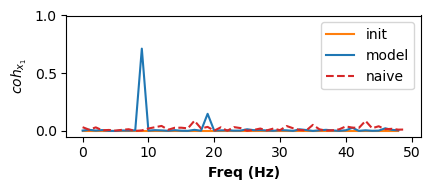

In [50]:
lw = 1.5
fig, ax = plt.subplots(1,1,figsize=(4.5,2), sharex=True)
# ax[0].plot(coh_true, color='k', label='true', linewidth=3)
# # ax.plot(coh_init, linestyle='--', color='tab:grey', label='init', linewidth=3)
# ax[1].plot(coh_model[-1], linestyle='--', color='tab:blue', label='init', linewidth=3)
# ax[2].plot(coh_naive, linestyle='--', color='tab:red', label='naive')
ax.plot(coh_init, linestyle='-', color='tab:orange', label='init', linewidth=lw)
ax.plot(coh_model[-1],  color='tab:blue', label='model', linewidth=lw)
ax.plot(coh_naive,  linestyle='--', color='tab:red', label='naive', linewidth=lw)
for i in range(3):
    ax.set_ylabel(r'$coh_{x_1}$', fontweight='bold')
    ax.legend()
    # ax.set_ylim([-1000,10000])
    ax.set_ylim([-0.05,1])
ax.set_xlabel('Freq (Hz)', fontweight='bold')
plt.tight_layout()

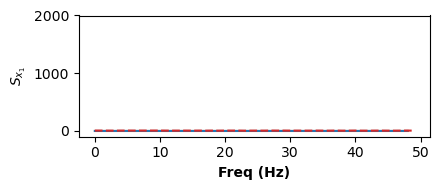

In [51]:
lw = 1.5
fig, ax = plt.subplots(1,1,figsize=(4.5,2), sharex=True)
# ax[0].plot(S_true, color='k', label='true', linewidth=3)
# # ax.plot(S_init, linestyle='--', color='tab:grey', label='init', linewidth=3)
# ax[1].plot(S_model[-1], linestyle='--', color='tab:blue', label='init', linewidth=3)
# ax[2].plot(S_naive, linestyle='--', color='tab:red', label='naive')
ax.plot(S_init, linestyle='-', color='tab:orange', label='init', linewidth=lw)
ax.plot(S_model[-1],  color='tab:blue', label='model', linewidth=lw)
ax.plot(S_naive,  linestyle='--', color='tab:red', label='naive', linewidth=lw)
for i in range(3):
    ax.set_ylabel(r'$S_{x_1}$', fontweight='bold')
    # ax.legend()
    ax.set_ylim([-100,2000])
ax.set_xlabel('Freq (Hz)', fontweight='bold')
plt.tight_layout()

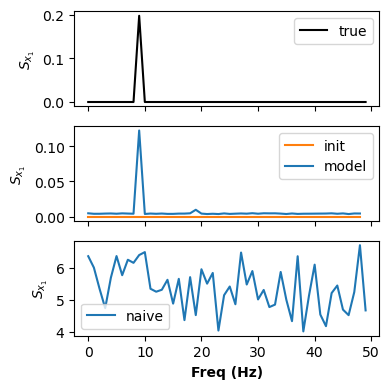

In [52]:
lw = 1.5
fig, ax = plt.subplots(3,1,figsize=(4,4), sharex=True)
# ax[0].plot(S_true, color='k', label='true', linewidth=3)
# # ax.plot(S_init, linestyle='--', color='tab:grey', label='init', linewidth=3)
# ax[1].plot(S_model[-1], linestyle='--', color='tab:blue', label='init', linewidth=3)
# ax[2].plot(S_naive, linestyle='--', color='tab:red', label='naive')
ax[0].plot(S_true, color='k', label='true', linewidth=lw)
ax[1].plot(S_init, linestyle='-', color='tab:orange', label='init', linewidth=lw)
ax[1].plot(S_model[-1],  color='tab:blue', label='model', linewidth=lw)
ax[2].plot(S_naive,  color='tab:blue', label='naive', linewidth=lw)
for i in range(3):
    ax[i].set_ylabel(r'$S_{x_1}$', fontweight='bold')
    ax[i].legend()
    # ax[i].set_ylim([-1000,10000])
ax[2].set_xlabel('Freq (Hz)', fontweight='bold')
plt.tight_layout()

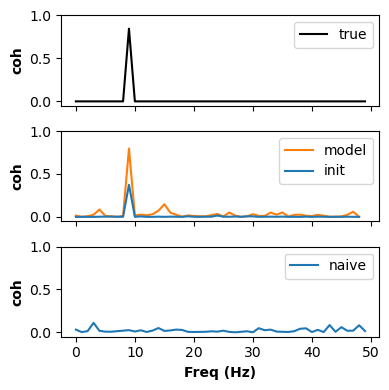

In [45]:
lw = 1.5
fig, ax = plt.subplots(3,1,figsize=(4,4), sharex=True)
# ax[0].plot(coh_true, color='k', label='true', linewidth=3)
# # ax.plot(coh_init, linestyle='--', color='tab:grey', label='init', linewidth=3)
# ax[1].plot(coh_model[-1], linestyle='--', color='tab:blue', label='init', linewidth=3)
# ax[2].plot(coh_naive, linestyle='--', color='tab:red', label='naive')
ax[0].plot(coh_true, color='k', label='true', linewidth=lw)
ax[1].plot(coh_init, linestyle='-', color='tab:orange', label='model', linewidth=lw)
ax[1].plot(coh_model[-1],  color='tab:blue', label='init', linewidth=lw)
ax[2].plot(coh_naive,  color='tab:blue', label='naive', linewidth=lw)
for i in range(3):
    ax[i].set_ylabel('coh', fontweight='bold')
    ax[i].legend()
    ax[i].set_ylim([-0.05,1])
ax[2].set_xlabel('Freq (Hz)', fontweight='bold')
plt.tight_layout()

In [33]:
model_load.keys()

dict_keys(['Gamma', 'latent_true', 'spikes', 'lams', 'tapers', 'Wv', 'track', 'inv_init'])

In [31]:
thr_coherence
thr_coherence(model_load['Gamma'])

array([7.00193700e-03, 5.69660871e-03, 4.63343996e-03, 1.00087699e-03,
       4.73803223e-03, 1.01651096e-02, 6.60502719e-03, 2.58468819e-03,
       1.78229257e-02, 7.62405532e-01, 8.83759613e-05, 1.36602187e-02,
       1.04224122e-04, 8.93311182e-03, 1.98714437e-03, 9.88097219e-03,
       9.90132057e-03, 9.14597822e-03, 1.87208450e-02, 1.38095935e-06,
       3.17563627e-03, 1.19168243e-04, 2.70296037e-04, 5.26837515e-03,
       2.54181146e-03, 5.37725397e-03, 1.39737581e-03, 4.33019378e-03,
       7.94832185e-03, 3.14540007e-03, 4.01537255e-04, 1.49127770e-02,
       1.91830602e-02, 2.72181736e-04, 2.57893494e-03, 4.70824844e-03,
       1.51286485e-03, 9.42468097e-03, 6.58212029e-03, 6.83916813e-03,
       7.61413165e-03, 9.57855448e-03, 1.56875353e-04, 9.32675014e-03,
       1.63529189e-03, 2.07364779e-04, 4.12026503e-03, 4.08363666e-03,
       4.84152411e-03])

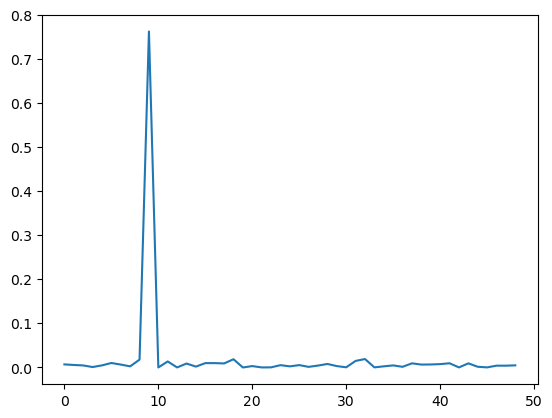

In [32]:
# plt.plot(thr_coherence())
plt.plot(thr_coherence(model_load['Gamma']))

400.0
400.0
400.0
400.0


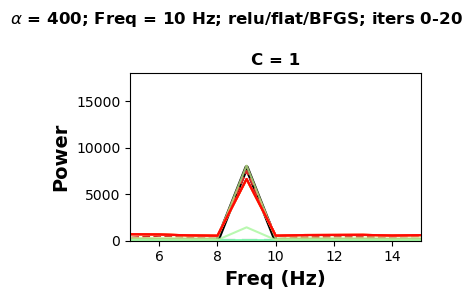

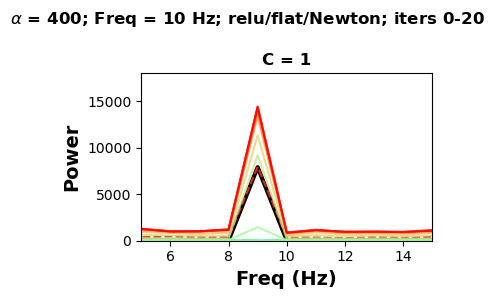

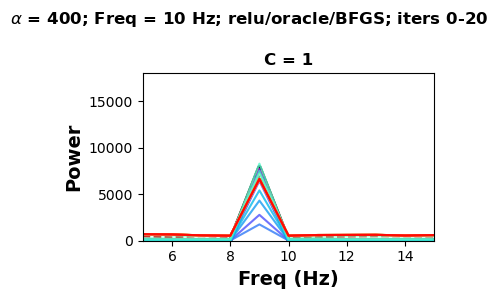

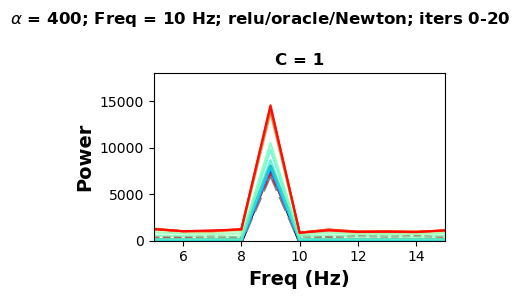

In [12]:
seed = 7
delta = 1e-3
sample_length=1000
fs = 1000
J = sample_length/2

j_ind=9
# for init_type in ['flat']:
alpha = 400
for init_type in ['flat', 'oracle']:
    for optim_type in ['BFGS', 'Newton']:
    # for optim_type in ['BFGS']:

        # alphas = [400, 600, 800, 1000]
        # Cs = [1, 2, 5, 10]
        C = 1
        logS = False
        iters_show = [0,20]
        fig, ax = plt.subplots(1,1,figsize=(4,3), sharey=True)
        # for a, alpha in enumerate(alphas):
        # Cs = [1]
        alpha = float(alpha)
        plot_res_S('relu', init_type, optim_type, alpha, logS, iters_show, ax=ax, k=1, scaling_factor=scaling_factor, title=False, emiter=20, C=C, seed=seed)
        ax.set_title(f'C = {C}', fontweight='bold')
        ax.set_xlim([5,15])
        # ax[a].set_ylim([-5,2500])
        ax.set_ylim([-20, 18000])

        fig.suptitle('$\\alpha$ = %i; ' % alpha + f'Freq = {j_ind+1} Hz; {link}/{init_type}/{optim_type}; iters {iters_show[0]}-{iters_show[1]}', fontweight='bold', fontsize=12)
        plt.tight_layout()


400.0
400.0
400.0
400.0


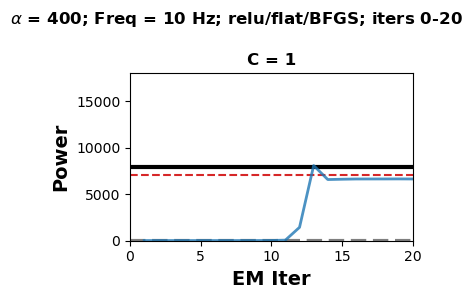

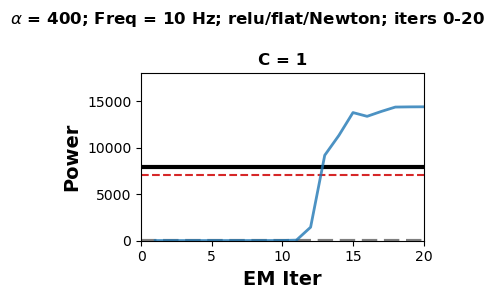

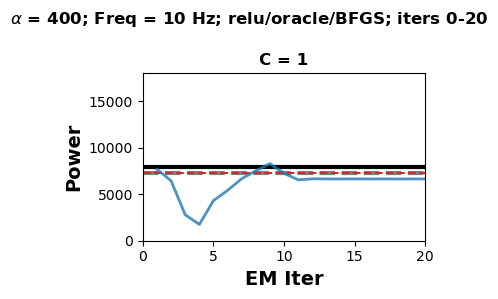

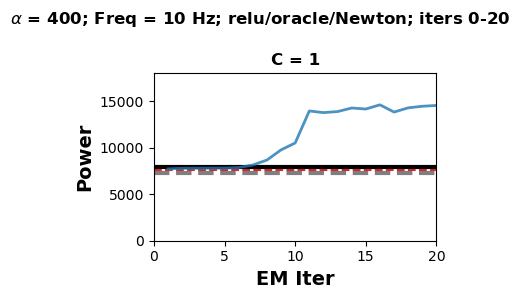

In [20]:

seed = 7
delta = 1e-3
sample_length=1000
fs = 1000
J = sample_length/2

j_ind=9
# for init_type in ['flat']:
alpha = 400
for init_type in ['flat', 'oracle']:
    for optim_type in ['BFGS', 'Newton']:
    # for optim_type in ['BFGS']:

        # alphas = [400, 600, 800, 1000]
        # Cs = [1, 2, 5, 10]
        C = 1
        logS = False
        iters_show = [0,20]
        fig, ax = plt.subplots(1,1,figsize=(4,3), sharey=True)
        # for a, alpha in enumerate(alphas):
        # Cs = [1]
        alpha = float(alpha)
        plot_res_S10('relu', init_type, optim_type, alpha, logS, iters_show, ax=ax, k=1, scaling_factor=scaling_factor, title=False, emiter=20, C=C, seed=seed)
        ax.set_title(f'C = {C}', fontweight='bold')
        ax.set_xlim([0,20])
        # ax[a].set_ylim([-5,2500])
        ax.set_ylim([-20, 18000])

        fig.suptitle('$\\alpha$ = %i; ' % alpha + f'Freq = {j_ind+1} Hz; {link}/{init_type}/{optim_type}; iters {iters_show[0]}-{iters_show[1]}', fontweight='bold', fontsize=12)
        plt.tight_layout()
